# Outlier detecion

Будем использовать библиотеку pyod (pip install pyod)

In [1]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA

from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

### Сгенерируем набор точек для задачи поиска выбросов

Populating the interactive namespace from numpy and matplotlib


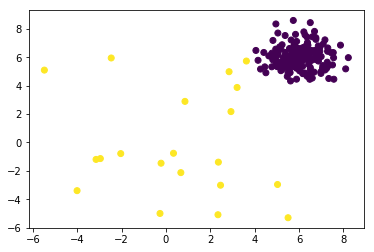

In [18]:
from pyod.utils.data import generate_data
from matplotlib import pylab as plt
%pylab inline

contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points

# Generate sample data
X_train, y_train, X_test, y_test = \
    generate_data(n_train=n_train,
                  n_test=n_test,
                  n_features=2,
                  contamination=contamination,
                  random_state=42)

plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.show()

### Применим KNN для нахождения выбросов

In [19]:
from pyod.models.knn import KNN   # kNN detector

# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

### Посмотрим на качество алгоритма

In [20]:
from pyod.utils.data import evaluate_print

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.9992, precision @ rank n:0.95

On Test Data:
KNN ROC:1.0, precision @ rank n:1.0


### Визуализируем результат

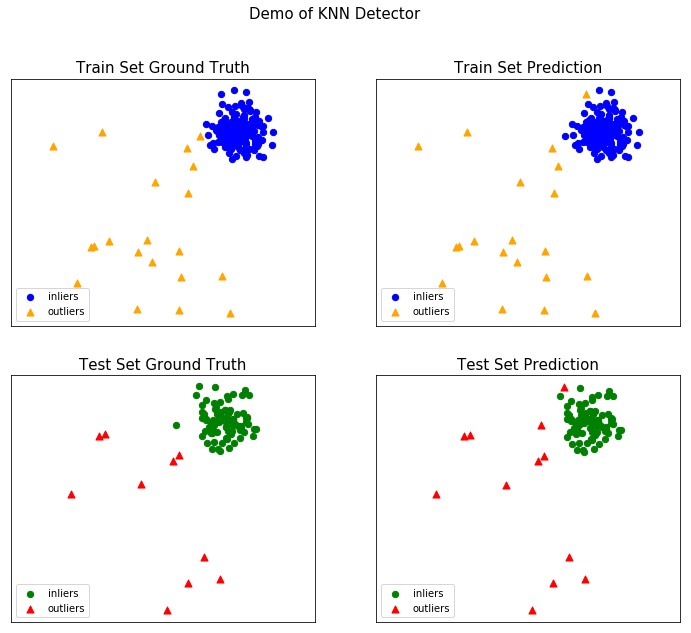

In [24]:
from pyod.utils.example import visualize
    
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
    y_test_pred, show_figure=True, save_figure=False)

### Сравним различные алгоритмы для нахождения выбросов по времени работы и качеству

Загрузим данные и информацию о проценте выбросов

In [ ]:
mat_file = 'arrhythmia.mat'

random_state = np.random.RandomState(42)

df_columns = ['Characteristics', 'Data', '#Samples', '# Dimensions', 'Outlier Perc',
              'ABOD', 'CBLOF', 'FB', 'HBOS', 'IForest', 'KNN', 'LOF', 'MCD',
              'OCSVM', 'PCA']

mat = loadmat(mat_file)

X = mat['X']
y = mat['y'].ravel()
outliers_fraction = np.count_nonzero(y) / len(y)
outliers_percentage = round(outliers_fraction * 100, ndigits=4)

# construct containers for saving results
roc_list = ['ROC-AUC',mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
prn_list = ['Precision@N',mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
time_list = ['Time', mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]

Разобъем данные на тренировочную и валидационную части и масштабируем их.

In [ ]:
# 60% data for training and 40% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=random_state)

# standardizing data for processing
X_train_norm, X_test_norm = standardizer(X_train, X_test)

Применим различные алгоритмы нахождения выбросов

In [5]:

classifiers = {'Angle-based Outlier Detector (ABOD)': ABOD(
    contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor': CBLOF(
        contamination=outliers_fraction, check_estimator=False,
        random_state=random_state),
    'Feature Bagging': FeatureBagging(contamination=outliers_fraction,
                                     random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Local Outlier Factor (LOF)': LOF(
        contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
}

for clf_name, clf in classifiers.items():
    t0 = time()
    #обучите алгоритм на X_train_norm
    clf.fit(X_train_norm)
    #test_scores = сделайте предсказание (decision_function) на X_test_norm
    test_scores = clf.decision_function(X_test_norm)
    t1 = time()
    duration = round(t1 - t0, ndigits=4)
    time_list.append(duration)

    #вычислите roc_auc_score и precision_n_scores для тестовых данных (y_test, test_scores)
#     roc = #your code here
#     prn = #your code here
    roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
    prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

    print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
          'execution time: {duration}s'.format(
        clf_name=clf_name, roc=roc, prn=prn, duration=duration))

    roc_list.append(roc)
    prn_list.append(prn)
    

df_time = pd.DataFrame([time_list],columns=df_columns)
df_roc = pd.DataFrame([roc_list],columns=df_columns)
df_prn = pd.DataFrame([prn_list],columns=df_columns)

df_res = pd.concat([df_time, df_roc, df_prn], axis=0)

Angle-based Outlier Detector (ABOD) ROC:0.7687, precision @ rank n:0.3571, execution time: 0.6044s
Cluster-based Local Outlier Factor ROC:0.7824, precision @ rank n:0.4643, execution time: 0.7681s
Feature Bagging ROC:0.7796, precision @ rank n:0.4643, execution time: 0.4348s
Histogram-base Outlier Detection (HBOS) ROC:0.8511, precision @ rank n:0.5714, execution time: 0.6118s
Isolation Forest ROC:0.8639, precision @ rank n:0.6071, execution time: 0.169s
K Nearest Neighbors (KNN) ROC:0.782, precision @ rank n:0.5, execution time: 0.0608s
Local Outlier Factor (LOF) ROC:0.7787, precision @ rank n:0.4643, execution time: 0.0519s
Minimum Covariance Determinant (MCD) ROC:0.8228, precision @ rank n:0.4286, execution time: 0.4467s
One-class SVM (OCSVM) ROC:0.7986, precision @ rank n:0.5, execution time: 0.0312s
Principal Component Analysis (PCA) ROC:0.7997, precision @ rank n:0.5, execution time: 0.0625s


In [25]:
#выведите на экран таблицу с результатами
df_res

,Characteristics,Data,#Samples,# Dimensions,Outlier Perc,ABOD,CBLOF,FB,HBOS,IForest,KNN,LOF,MCD,OCSVM,PCA
0,Time,arrhythmia,452,274,14.6018,0.6044,0.7681,0.4348,0.6118,0.1690,0.0608,0.0519,0.4467,0.0312,0.0625
0,ROC-AUC,arrhythmia,452,274,14.6018,0.7687,0.7824,0.7796,0.8511,0.8639,0.7820,0.7787,0.8228,0.7986,0.7997
0,Precision@N,arrhythmia,452,274,14.6018,0.3571,0.4643,0.4643,0.5714,0.6071,0.5000,0.4643,0.4286,0.5000,0.5000


### Попробуем определить долю выбросов в датасете

In [75]:
data = pd.read_csv("heart.csv")
X = data.copy()
y = data['target']
del X['target']
print(data.shape)

(303, 14)


In [76]:
# data = pd.read_csv('yeast.data', sep=" ", header=None, error_bad_lines=False)
# data = data[[2,4,6,8,10,12,14,16]]
# data.head()

In [89]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

age         13.5
sex          1.0
cp           2.0
trestbps    20.0
chol        63.5
fbs          0.0
restecg      1.0
thalach     32.5
exang        1.0
oldpeak      1.6
slope        1.0
ca           1.0
thal         1.0
dtype: float64


In [98]:
X_wo_out = X[~((X < (Q1 - 3 * IQR)) |(X > (Q3 + 3 * IQR))).any(axis=1)]
y_wo_out = y[~((X < (Q1 - 3 * IQR)) |(X > (Q3 + 3 * IQR))).any(axis=1)]

In [99]:
X_wo_out.shape, y_wo_out.shape

((257, 13), (257,))

In [97]:
len(X_wo_out) / len(X)

0.8481848184818482

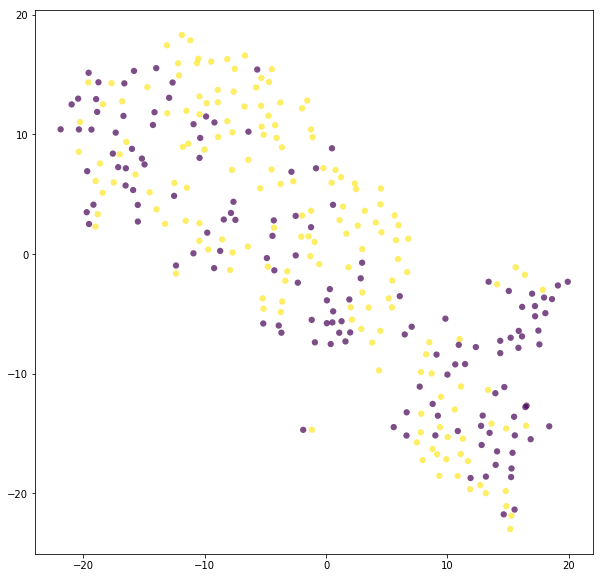

Wall time: 1.38 s


In [93]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE()

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, edgecolor='none', alpha=0.7, s=40)
plt.show()

In [105]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

cross_val_score(LogisticRegression(), X, y, cv=3).mean()

0.834983498349835

In [108]:
cross_val_score(LogisticRegression(), X_wo_out, y_wo_out, cv=3).mean()

0.8363885088919288

In [112]:
outliers_fraction = 0.15

classifiers = {'Angle-based Outlier Detector (ABOD)': ABOD(
    contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor': CBLOF(
        contamination=outliers_fraction, check_estimator=False,
        random_state=random_state),
    'Feature Bagging': FeatureBagging(contamination=outliers_fraction,
                                     random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Local Outlier Factor (LOF)': LOF(
        contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
}

for clf_name, clf in classifiers.items():
    clf.fit(X)
    y_pred = clf.labels_ 
    
    X_wo = X[y_pred==0]
    y_wo = y[y_pred==0]
    
    print(clf_name, cross_val_score(LogisticRegression(), X_wo, y_wo, cv=3).mean())

Angle-based Outlier Detector (ABOD) 0.7897400820793434
Cluster-based Local Outlier Factor 0.8207934336525308
Feature Bagging 0.8052895576835385
Histogram-base Outlier Detection (HBOS) 0.8288933964390353
Isolation Forest 0.8403556771545828
K Nearest Neighbors (KNN) 0.7974464204286367
Local Outlier Factor (LOF) 0.8052439580483356
Minimum Covariance Determinant (MCD) 0.8518467852257182
One-class SVM (OCSVM) 0.8206896551724138
Principal Component Analysis (PCA) 0.8363885088919288
